In [1]:
import torch
torch.cuda.is_available(), torch.cuda.get_device_name(0)


(True, 'Tesla T4')

In [2]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
Tesla T4


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip "/content/drive/MyDrive/CSE425/IRMAS-TrainingData.zip" -d /content/data



Streaming output truncated to the last 5000 lines.
  inflating: /content/data/IRMAS-TrainingData/gac/[gac][pop_roc]0547__3.wav  
  inflating: /content/data/IRMAS-TrainingData/gac/[gac][pop_roc]0550__1.wav  
  inflating: /content/data/IRMAS-TrainingData/gac/[gac][pop_roc]0550__2.wav  
  inflating: /content/data/IRMAS-TrainingData/gac/[gac][pop_roc]0550__3.wav  
  inflating: /content/data/IRMAS-TrainingData/gac/[gac][pop_roc]0556__1.wav  
  inflating: /content/data/IRMAS-TrainingData/gac/[gac][pop_roc]0556__2.wav  
  inflating: /content/data/IRMAS-TrainingData/gac/[gac][pop_roc]0556__3.wav  
  inflating: /content/data/IRMAS-TrainingData/gac/[gac][pop_roc]0557__1.wav  
  inflating: /content/data/IRMAS-TrainingData/gac/[gac][pop_roc]0557__2.wav  
  inflating: /content/data/IRMAS-TrainingData/gac/[gac][pop_roc]0557__3.wav  
  inflating: /content/data/IRMAS-TrainingData/gac/[gac][pop_roc]0558__1.wav  
  inflating: /content/data/IRMAS-TrainingData/gac/[gac][pop_roc]0558__2.wav  
  inflating: 

In [5]:
!ls /content/data/IRMAS-TrainingData



cel  cla  flu  gac  gel  org  pia  README.txt  sax  tru  vio  voi


In [9]:
!pip -q install -U torch torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip -q install librosa soundfile numpy scipy scikit-learn matplotlib umap-learn tqdm pandas


In [6]:
import torch, librosa, sklearn, umap
print("CUDA:", torch.cuda.is_available(), torch.cuda.get_device_name(0))
print("Librosa:", librosa.__version__)
print("Sklearn:", sklearn.__version__)


CUDA: True Tesla T4
Librosa: 0.11.0
Sklearn: 1.6.1


In [7]:
import os, glob, numpy as np, torch, librosa
from tqdm import tqdm
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import umap


In [9]:
import os, glob, numpy as np, librosa
from tqdm import tqdm

DATA_DIR = "/content/data/IRMAS-TrainingData"

SR = 22050
DURATION = 3.0
SAMPLES = int(SR * DURATION)
N_MELS = 128

X, y = [], []

labels = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
label_map = {l:i for i,l in enumerate(labels)}

print("Labels:", labels)

for label in labels:
    files = glob.glob(os.path.join(DATA_DIR, label, "*.wav"))
    for f in tqdm(files, desc=f"Loading {label}"):
        audio, _ = librosa.load(f, sr=SR)
        audio = audio[:SAMPLES]
        if len(audio) < SAMPLES:
            audio = np.pad(audio, (0, SAMPLES - len(audio)))

        mel = librosa.feature.melspectrogram(
            y=audio,
            sr=SR,
            n_mels=N_MELS
        )
        mel = librosa.power_to_db(mel)

        X.append(mel)
        y.append(label_map[label])

X = np.array(X)
y = np.array(y)

print("Final shape:", X.shape)



Labels: ['cel', 'cla', 'flu', 'gac', 'gel', 'org', 'pia', 'sax', 'tru', 'vio', 'voi']


Loading voi: 100%|██████████| 778/778 [00:14<00:00, 51.90it/s]


Final shape: (6705, 128, 130)


In [10]:
import torch

# global normalization
Xn = (X - X.mean()) / (X.std() + 1e-8)

# to torch: [N, 1, 128, 130]
Xt = torch.tensor(Xn).unsqueeze(1).float()
yt = torch.tensor(y).long()

device = "cuda" if torch.cuda.is_available() else "cpu"
Xt = Xt.to(device)
yt = yt.to(device)

Xt.shape, yt.shape, device


(torch.Size([6705, 1, 128, 130]), torch.Size([6705]), 'cuda')

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BetaVAE(nn.Module):
    def __init__(self, input_shape=(1,128,130), latent_dim=32):
        super().__init__()
        self.latent_dim = latent_dim

        self.enc = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU()
        )

        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            h = self.enc(dummy)
            self.enc_out_shape = h.shape[1:]
            self.flat_dim = int(h.numel())

        self.fc_mu = nn.Linear(self.flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flat_dim, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, self.flat_dim)

        self.dec = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1)
        )

    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.enc(x)
        hflat = h.view(x.size(0), -1)
        mu = self.fc_mu(hflat)
        logvar = self.fc_logvar(hflat)
        z = self.reparam(mu, logvar)

        h2 = self.fc_dec(z).view(x.size(0), *self.enc_out_shape)
        xr = self.dec(h2)


        xr = F.interpolate(xr, size=(x.size(2), x.size(3)), mode="bilinear", align_corners=False)
        return xr, mu, logvar

print("BetaVAE pika pika!")




BetaVAE fixed: recon will always match input size exactly.


In [18]:
from torch.utils.data import TensorDataset, DataLoader

latent_dim = 32
beta = 4.0
epochs = 35
batch_size = 128
lr = 1e-3

model = BetaVAE(input_shape=(1,128,130), latent_dim=latent_dim).to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr)

ds = TensorDataset(Xt)
dl = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True)

model.train()
for e in range(1, epochs+1):
    total = 0.0
    for (xb,) in dl:
        xr, mu, logvar = model(xb)
        recon = F.mse_loss(xr, xb)
        kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon + beta * kl

        opt.zero_grad()
        loss.backward()
        opt.step()

        total += loss.item() * xb.size(0)

    if e % 5 == 0 or e == 1:
        print(f"Epoch {e:02d} | loss {total/len(ds):.4f} | recon {recon.item():.4f} | kl {kl.item():.4f}")


Epoch 01 | loss 0.6848 | recon 0.5167 | kl 0.0187
Epoch 05 | loss 0.4465 | recon 0.3179 | kl 0.0226
Epoch 10 | loss 0.4381 | recon 0.3265 | kl 0.0281
Epoch 15 | loss 0.4324 | recon 0.3307 | kl 0.0237
Epoch 20 | loss 0.4343 | recon 0.3231 | kl 0.0312
Epoch 25 | loss 0.4332 | recon 0.3433 | kl 0.0256
Epoch 30 | loss 0.4333 | recon 0.3033 | kl 0.0303
Epoch 35 | loss 0.4326 | recon 0.3327 | kl 0.0259


In [19]:
import numpy as np
import torch

model.eval()
with torch.no_grad():
    xr, mu, logvar = model(Xt)

Z = mu.detach().cpu().numpy()
Xrec = xr.detach().cpu().numpy()
Xorig = Xt.detach().cpu().numpy()
y_cpu = y.copy()

print("Z:", Z.shape, "Xrec:", Xrec.shape)


Z: (6705, 32) Xrec: (6705, 1, 128, 130)


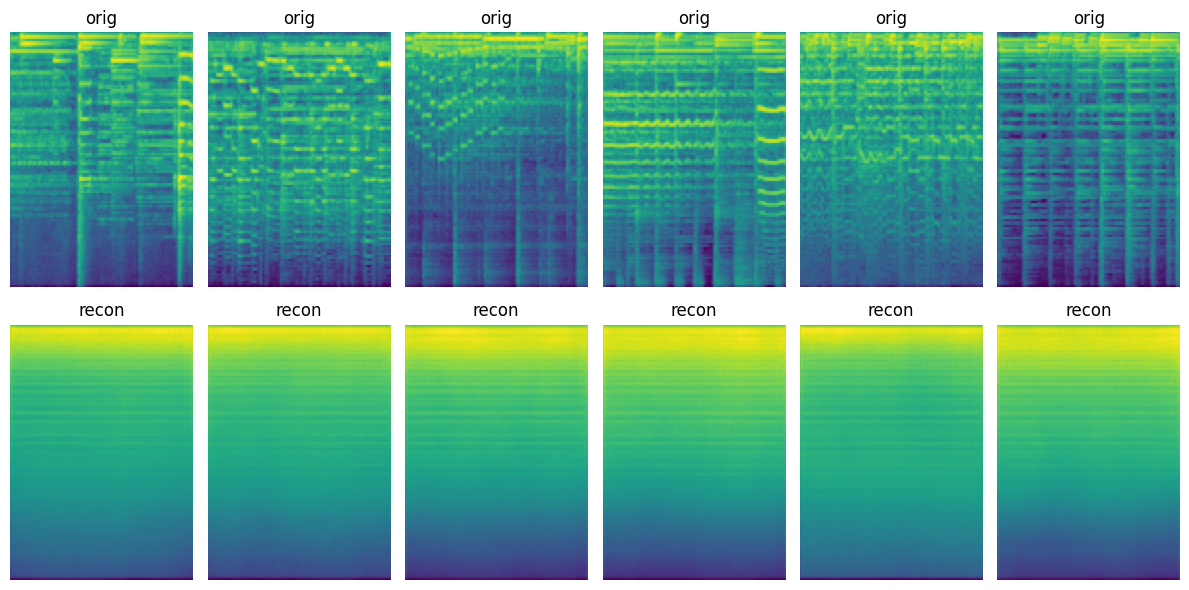

In [20]:
import matplotlib.pyplot as plt

idx = np.random.choice(len(Xorig), 6, replace=False)
plt.figure(figsize=(12,6))
for i,k in enumerate(idx):
    plt.subplot(2,6,i+1)
    plt.imshow(Xorig[k,0], aspect='auto')
    plt.axis("off")
    plt.title("orig")
    plt.subplot(2,6,6+i+1)
    plt.imshow(Xrec[k,0], aspect='auto')
    plt.axis("off")
    plt.title("recon")
plt.tight_layout()
plt.show()


In [21]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Xflat = Xn.reshape(len(Xn), -1)
Xp = PCA(n_components=32, random_state=0).fit_transform(Xflat)

k_pca = KMeans(n_clusters=11, random_state=0, n_init="auto").fit_predict(Xp)
print("PCA+KMeans pika pika!")


PCA+KMeans done


In [22]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

class ConvAE(nn.Module):
    def __init__(self, input_shape=(1,128,130), latent_dim=32):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU()
        )
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            h = self.enc(dummy)
            self.enc_out_shape = h.shape[1:]
            self.flat_dim = int(h.numel())

        self.fc_z = nn.Linear(self.flat_dim, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, self.flat_dim)

        self.dec = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1)
        )

    def forward(self, x):
        h = self.enc(x)
        hflat = h.view(x.size(0), -1)
        z = self.fc_z(hflat)
        h2 = self.fc_dec(z).view(x.size(0), *self.enc_out_shape)
        xr = self.dec(h2)
        xr = F.interpolate(xr, size=(x.size(2), x.size(3)), mode="bilinear", align_corners=False)
        return xr, z

ae = ConvAE(input_shape=(1,128,130), latent_dim=32).to(device)
opt2 = torch.optim.Adam(ae.parameters(), lr=1e-3)

ds = TensorDataset(Xt)
dl = DataLoader(ds, batch_size=128, shuffle=True, drop_last=True)

ae.train()
for e in range(1, 16):
    total = 0.0
    for (xb,) in dl:
        xr, z = ae(xb)
        loss = F.mse_loss(xr, xb)
        opt2.zero_grad()
        loss.backward()
        opt2.step()
        total += loss.item() * xb.size(0)
    if e % 5 == 0 or e == 1:
        print(f"AE Epoch {e:02d} | loss {total/len(ds):.4f}")

ae.eval()
with torch.no_grad():
    _, Zae = ae(Xt)
Zae = Zae.detach().cpu().numpy()

k_ae = KMeans(n_clusters=11, random_state=0, n_init="auto").fit_predict(Zae)
print("AE latent + KMeans pika pika")


AE Epoch 01 | loss 0.4887
AE Epoch 05 | loss 0.1953
AE Epoch 10 | loss 0.1777
AE Epoch 15 | loss 0.1703
AE latent + KMeans done


In [23]:
from sklearn.cluster import AgglomerativeClustering

k_vae = KMeans(n_clusters=11, random_state=0, n_init="auto").fit_predict(Z)
agg_vae = AgglomerativeClustering(n_clusters=11).fit_predict(Z)

print("Clustering on Beta-VAE pika pika")


Clustering on Beta-VAE done


In [24]:
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import pandas as pd
import numpy as np

def purity_score(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    total = 0
    for c in np.unique(y_pred):
        idx = np.where(y_pred == c)[0]
        if len(idx) == 0:
            continue
        _, counts = np.unique(y_true[idx], return_counts=True)
        total += counts.max()
    return total / len(y_true)

def eval_all(name, feats, pred):
    return {
        "method": name,
        "silhouette": float(silhouette_score(feats, pred)),
        "calinski_harabasz": float(calinski_harabasz_score(feats, pred)),
        "davies_bouldin": float(davies_bouldin_score(feats, pred)),
        "ARI": float(adjusted_rand_score(y_cpu, pred)),
        "NMI": float(normalized_mutual_info_score(y_cpu, pred)),
        "purity": float(purity_score(y_cpu, pred)),
    }

rows = [
    eval_all("PCA(32)+KMeans", Xp, k_pca),
    eval_all("AE(32)+KMeans", Zae, k_ae),
    eval_all("BetaVAE(32)+KMeans", Z, k_vae),
    eval_all("BetaVAE(32)+Agglomerative", Z, agg_vae),
]
df = pd.DataFrame(rows)
df


,method,silhouette,calinski_harabasz,davies_bouldin,ARI,NMI,purity
0,PCA(32)+KMeans,0.129163,2321.128418,1.870464,0.056179,0.109707,0.241163
1,AE(32)+KMeans,0.108543,1351.327026,2.068322,0.063950,0.121672,0.258315
2,BetaVAE(32)+KMeans,0.474819,35889.445312,0.579207,0.041541,0.092451,0.214019
3,BetaVAE(32)+Agglomerative,0.411421,29225.070312,0.609076,0.036936,0.089432,0.209098


In [25]:
import os
os.makedirs("results", exist_ok=True)
df.to_csv("results/clustering_metrics.csv", index=False)
print("Saved -> results/clustering_metrics.csv")


Saved -> results/clustering_metrics.csv


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


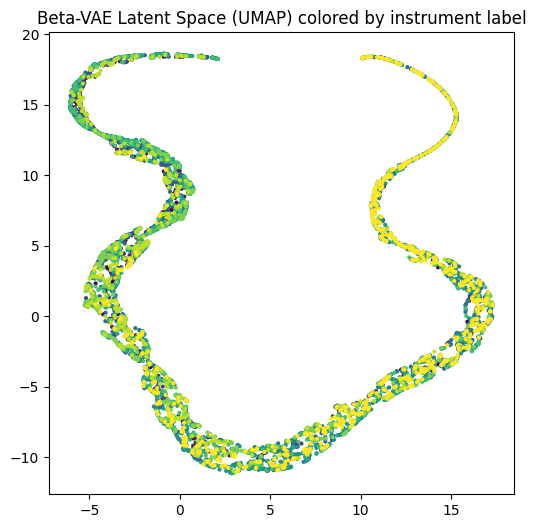

In [26]:
import umap
import matplotlib.pyplot as plt

emb = umap.UMAP(random_state=0).fit_transform(Z)

plt.figure(figsize=(6,6))
plt.scatter(emb[:,0], emb[:,1], c=y_cpu, s=4)
plt.title("Beta-VAE Latent Space (UMAP) colored by instrument label")
plt.show()


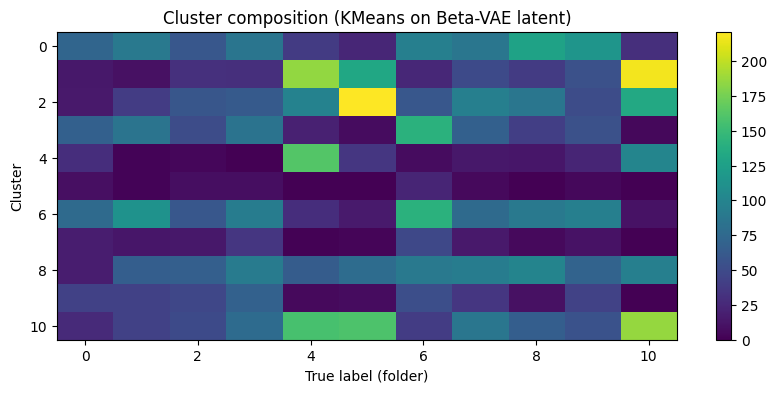

In [27]:
import numpy as np
import matplotlib.pyplot as plt

pred = k_vae
K = 11
counts = np.zeros((K, K), dtype=int)

for i in range(K):
    idx = np.where(pred == i)[0]
    if len(idx)==0:
        continue
    vals, cts = np.unique(y_cpu[idx], return_counts=True)
    for v, ct in zip(vals, cts):
        counts[i, v] = ct

plt.figure(figsize=(10,4))
plt.imshow(counts, aspect="auto")
plt.xlabel("True label (folder)")
plt.ylabel("Cluster")
plt.title("Cluster composition (KMeans on Beta-VAE latent)")
plt.colorbar()
plt.show()


In [28]:
import numpy as np, json, os

os.makedirs("results", exist_ok=True)
np.save("results/latent_beta_vae.npy", Z)
np.save("results/latent_ae.npy", Zae)
np.save("results/labels.npy", y_cpu)

label_names = ['cel','cla','flu','gac','gel','org','pia','sax','tru','vio','voi']
with open("results/label_names.json","w") as f:
    json.dump({i:n for i,n in enumerate(label_names)}, f)

print("Saved latents + labels into results/")


Saved latents + labels into results/


In [29]:
!zip -r results.zip results
from google.colab import files
files.download("results.zip")


  adding: results/ (stored 0%)
  adding: results/clustering_metrics.csv (deflated 39%)
  adding: results/labels.npy (deflated 100%)
  adding: results/label_names.json (deflated 38%)
  adding: results/latent_beta_vae.npy (deflated 7%)
  adding: results/latent_ae.npy (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>